In [0]:
!wget --no-verbose https://raw.githubusercontent.com/gisandnes/introduction_to_ml_with_python/master/preamble.py -O preamble.py

2019-01-18 14:10:47 URL:https://raw.githubusercontent.com/gisandnes/introduction_to_ml_with_python/master/preamble.py [774/774] -> "preamble.py" [1]


In [0]:
!pip install mglearn

    100% |████████████████████████████████| 542kB 23.8MB/s 
  Running setup.py bdist_wheel for mglearn ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [0]:
from preamble import *
%matplotlib inline

## Algorithm Chains and Pipelines

In [0]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

In [0]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Parameter Selection with Preprocessing 

In [0]:
from sklearn.model_selection import GridSearchCV
# for illustration purposes only, don't use this code!
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


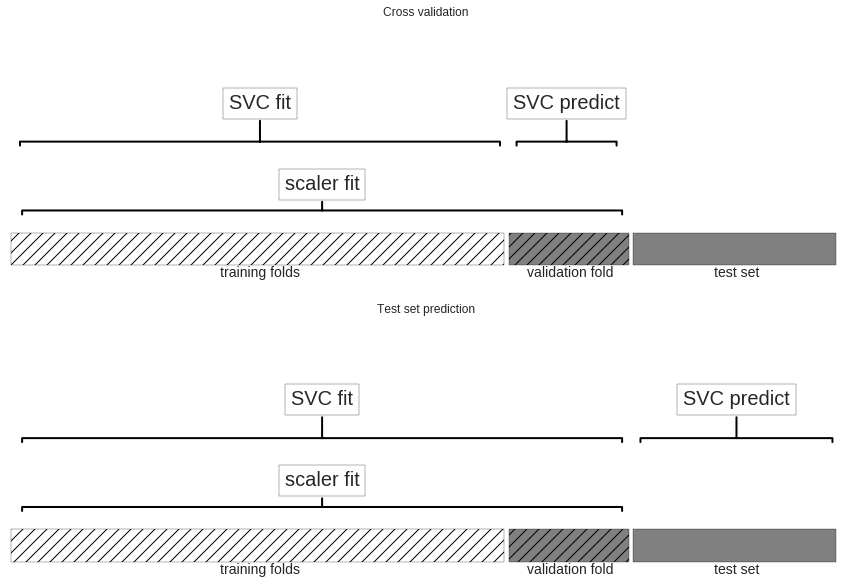

In [0]:
mglearn.plots.plot_improper_processing()

### Building Pipelines

In [0]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [0]:
pipe.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [0]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


### Using Pipelines in Grid-searches

In [0]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [0]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


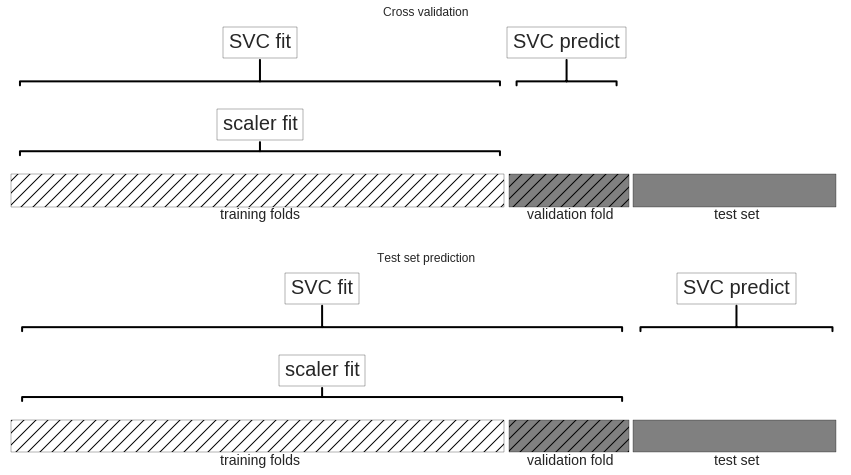

In [0]:
mglearn.plots.plot_proper_processing()

In [0]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [0]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


In [0]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


### The General Pipeline Interface

In [0]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [0]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

![pipeline_illustration](https://github.com/gisandnes/introduction_to_ml_with_python/blob/master/images/pipeline.png?raw=1)

### Convenient Pipeline creation with ``make_pipeline``

In [0]:
from sklearn.pipeline import make_pipeline
# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [0]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


#### Accessing step attributes

In [0]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


#### Accessing Attributes in a Pipeline inside GridSearchCV

In [0]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [0]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])


In [0]:
print("Logistic regression step:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [0]:
print("Logistic regression coefficients:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.389 -0.375 -0.376 -0.396 -0.115  0.017 -0.355 -0.39  -0.058  0.209
  -0.495 -0.004 -0.371 -0.383 -0.045  0.198  0.004 -0.049  0.21   0.224
  -0.547 -0.525 -0.499 -0.515 -0.393 -0.123 -0.388 -0.417 -0.325 -0.139]]


### Grid-searching preprocessing steps and model parameters

In [0]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [0]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [0]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

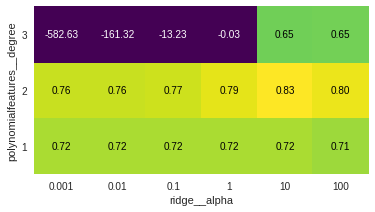

In [0]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

In [0]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [0]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [0]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [0]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


#### Avoiding Redundant Computation





In [0]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

#### Summary and Outlook 

#### Ekstra by Geir Inge

In [0]:
#Explore tables:
cancer.data.shape

(569, 30)

In [0]:
from sklearn.dummy import DummyClassifier

pipe = Pipeline([('preprocessing', None), ('classifier', DummyClassifier())])

In [0]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

param_grid = [
    {'classifier': [SVC()], 
     'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 
     'classifier__max_features': [1, 2, 3]},
    #Added by GIS
    {'classifier': [xgb.XGBClassifier(n_estimators=500, n_jobs=-1)], 
     'preprocessing': [StandardScaler(), None],
     'classifier__max_depth': [1, 3, 5, 10],
     'classifier__learning_rate': [0.001, 0.01, 0.1],
     'classifier__colsample_bytree': [0.1, 0.5, 1]
    }

]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=False)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.10f}".format(grid.best_score_))
print("Test-set score: {:.10f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.9859154930
Test-set score: 0.9790209790


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.shape

(147, 21)

In [0]:
cv_results[0:5]

,mean_fit_time,mean_score_time,mean_test_score,param_classifier,...,split4_test_score,std_fit_time,std_score_time,std_test_score
0,8.42e-03,1.79e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,0.63,5.02e-04,4.76e-05,2.86e-03
1,7.51e-03,1.78e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,0.63,2.34e-04,5.75e-05,2.86e-03
2,8.36e-03,1.80e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,0.63,2.53e-04,4.70e-05,2.86e-03
3,6.90e-03,1.76e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,0.63,2.78e-04,2.03e-04,2.86e-03
4,8.99e-03,1.86e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,0.63,1.91e-04,7.84e-05,2.86e-03


In [0]:
list(cv_results.columns.values)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_classifier',
 'param_classifier__C',
 'param_classifier__colsample_bytree',
 'param_classifier__gamma',
 'param_classifier__learning_rate',
 'param_classifier__max_depth',
 'param_classifier__max_features',
 'param_preprocessing',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [0]:
#report_cols = [i for i in list(cv_results.columns.values) if not("split" in i or "mean_fit_time" in i or "mean_score_time" in i or "std" in i or "params" in i or "rank_test_score" in i)]

#report_cols2 = [i for i in list(cv_results.columns.values) if i not in ["mean_fit_time", "mean_score_time", "params", "rank_test_score"] and not("split" in i or "std" in i)]

#print(report_cols)

#report_cols2

In [0]:
cv_results.dtypes

mean_fit_time                         float64
mean_score_time                       float64
mean_test_score                       float64
param_classifier                       object
param_classifier__C                    object
param_classifier__colsample_bytree     object
param_classifier__gamma                object
param_classifier__learning_rate        object
param_classifier__max_depth            object
param_classifier__max_features         object
param_preprocessing                    object
params                                 object
rank_test_score                         int32
split0_test_score                     float64
split1_test_score                     float64
split2_test_score                     float64
split3_test_score                     float64
split4_test_score                     float64
std_fit_time                          float64
std_score_time                        float64
std_test_score                        float64
dtype: object

In [0]:
display(cv_results.param_classifier__C.value_counts(dropna=False).to_frame())
display(cv_results.param_classifier__max_features.value_counts(dropna=False).to_frame())

,param_classifier__C
NaN,75
1.00e-03,12
1.00e-02,12
1.00e+01,12
1.00e+02,12
1.00e+00,12
1.00e-01,12


,param_classifier__max_features
NaN,144
3.0,1
2.0,1
1.0,1


In [0]:
np.max(cv_results.mean_test_score)

0.9859154929577465

In [0]:
cv_results = pd.DataFrame(grid.cv_results_)

report_cols = [i for i in list(cv_results.columns.values) if i not in ["mean_fit_time", "mean_score_time", "params", "rank_test_score"] and not("split" in i or "std" in i)]


cv_results["classifier"], _ = cv_results["param_classifier"].astype(str).str.split('(', 1).str
cv_results["scaler"], _ = cv_results["param_preprocessing"].astype(str).str.split('(', 1).str

report_cols = [i for i in report_cols if i not in["param_classifier", "param_preprocessing" ]]

cols = list(["classifier", "scaler"])
cols.extend(report_cols[1:])
cols.extend([report_cols[0]])

cv_results.loc[:, cols].sort_values(by=["mean_test_score"], ascending=[False])[0:20]

,classifier,scaler,param_classifier__C,param_classifier__colsample_bytree,...,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__max_features,mean_test_score
50,SVC,StandardScaler,10,NaN,...,NaN,NaN,NaN,0.99
60,SVC,StandardScaler,100,NaN,...,NaN,NaN,NaN,0.98
115,XGBClassifier,StandardScaler,NaN,0.5,...,0.1,1,NaN,0.98
62,SVC,StandardScaler,100,NaN,...,NaN,NaN,NaN,0.98
140,XGBClassifier,None,NaN,1,...,0.1,1,NaN,0.98
139,XGBClassifier,StandardScaler,NaN,1,...,0.1,1,NaN,0.98
116,XGBClassifier,None,NaN,0.5,...,0.1,1,NaN,0.98
118,XGBClassifier,None,NaN,0.5,...,0.1,3,NaN,0.97
117,XGBClassifier,StandardScaler,NaN,0.5,...,0.1,3,NaN,0.97
91,XGBClassifier,StandardScaler,NaN,0.1,...,0.1,1,NaN,0.97


In [0]:

cv_results.loc[:, "mean_test_score"][0:20]

0     0.63
1     0.63
2     0.63
3     0.63
4     0.63
5     0.63
6     0.63
7     0.63
8     0.63
9     0.63
10    0.63
11    0.63
12    0.63
13    0.63
14    0.63
15    0.63
16    0.63
17    0.63
18    0.63
19    0.63
Name: mean_test_score, dtype: float64

In [0]:
cv_results[0:20]

,mean_fit_time,mean_score_time,mean_test_score,param_classifier,...,std_score_time,std_test_score,classifier,scaler
0,8.42e-03,1.79e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,4.76e-05,2.86e-03,SVC,StandardScaler
1,7.51e-03,1.78e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,5.75e-05,2.86e-03,SVC,None
2,8.36e-03,1.80e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,4.70e-05,2.86e-03,SVC,StandardScaler
3,6.90e-03,1.76e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,2.03e-04,2.86e-03,SVC,None
4,8.99e-03,1.86e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,7.84e-05,2.86e-03,SVC,StandardScaler
5,6.12e-03,1.45e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,3.17e-05,2.86e-03,SVC,None
6,8.72e-03,1.84e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,6.31e-05,2.86e-03,SVC,StandardScaler
7,7.31e-03,1.77e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,1.26e-04,2.86e-03,SVC,None
8,9.88e-03,2.51e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,3.78e-04,2.86e-03,SVC,StandardScaler
9,7.68e-03,1.74e-03,0.63,"SVC(C=10, cache_size=200, class_weight=None, c...",...,3.14e-05,2.86e-03,SVC,None
